In [11]:
import csv

csvFile = open("BCHAIN-MKPRU.csv", "r")
reader = csv.reader(csvFile)
date={}
bitcoin = {}
i=0
for item in reader:
    if reader.line_num == 1:
        continue
    bitcoin[i] = float(item[1])
    date[i]=item[0]
    i=i+1

csvFile.close()

csvFile = open("LBMA-GOLD.csv", "r")
reader = csv.reader(csvFile)
j=0
gold = {}
for item in reader:
    if reader.line_num == 1:
        continue
    while(item[0]!=date[j]):
        gold[j] = 0
        j=j+1
    if(item[1]==''): gold[j]=0
    else: gold[j]=float(item[1])
    j=j+1

csvFile.close()

#print(gold)
#print(bitcoin)


In [12]:
def buy(C, G, B, date, kind, amount, allin=False):
    trade=0
    price=0
    a=0
    if(kind=='gold'):
        if(gold[date]==0): return 0
        a=ag
        price=gold[date]
        trade=amount*gold[date]*(1+a)
    if(kind=='bitcoin'):
        a=ab
        price=bitcoin[date]
        trade=amount*bitcoin[date]*(1+a)
    if(C<trade or allin==True):
        amount=C/(price*(1+a))
        C=0
        if(kind=='gold'): G=G+amount
        if(kind=='bitcoin'): B=B+amount
    else:
        C=C-trade
        if(kind=='gold'): G=G+amount
        if(kind=='bitcoin'): B=B+amount
    # if allin: print('buy all %s at %s'%(kind,date))
    # else: print('buy %f %s at %s'%(amount,kind,date))
    return C, G, B, amount

def sell(C, G, B, date, kind, amount, allin=False):
    price=0
    a=0
    if(kind=='gold'):
        if(gold[date]==0): return C, G, B, 0
        a=ag
        if(amount>G or allin==True): amount=G
        G=G-amount
        price=amount*gold[date]
    if(kind=='bitcoin'):
        a=ab
        if(amount>B or allin==True): amount=B
        B=B-amount
        price=amount*bitcoin[date]
    trade=price-price*a
    C=C+trade
    # if allin: print('sell all %s at %s'%(kind,date))
    # else: print('sell %f %s at %s'%(amount,kind,date))
    return C, G, B, amount

def average(start, kind, days, decay_rate=0.95):
    if(kind=='gold'):
        price=0
        count=0
        weight_sum=0
        now=start
        while(days>0):
            if(now<0):
                break
            if(gold[now]==0):
                days=days-1
                now=now-1
            else:
                factor=decay_rate**count
                price=price+gold[now]*factor
                weight_sum+=factor
                count=count+1
                now=now-1
                days=days-1
        if(count==0): return 0
        return (price/weight_sum)
    if(kind=='bitcoin'):
        price=0
        count=0
        weight_sum=0
        now=start
        while(days>0):
            if(now<0):
                break
            factor=decay_rate**count
            price=price+bitcoin[now]*factor
            weight_sum+=factor
            count=count+1
            now=now-1
            days=days-1
        if(count==0): return 0
        return (price/weight_sum)
    
def rate(start, kind, P, L, decay_rate=0.95):
    priceP=average(start, kind, P, decay_rate)
    priceL=average(start, kind, L, decay_rate)
    if(priceL==0): return 0
    return (priceL-priceP)/priceP

In [13]:
def result(C, B, G, Days, ag, ab, L, P, sellGold=0, buyGold=0, sellbitcoin=0, buybitcoin=0, decay_rate=0.95):
    for i in range(Days):
        if(i<P): continue
        rateGold=rate(i, 'gold', P, L,decay_rate)
        rateBitcoin=rate(i, 'bitcoin', P, L,decay_rate)
        if(gold[i]!=0):
            if(rateGold>0 and rateBitcoin<=0):
                C, G, B, amount=sell(C, G, B, i, 'bitcoin', amount=0, allin=True)
                C, G, B, amount=buy(C, G, B, i, 'gold', amount=0, allin=True)
            if(rateGold<=0 and rateBitcoin>0):
                C, G, B, amount=sell(C, G, B, i, 'gold', amount=0, allin=True)
                C, G, B, amount=buy(C, G, B, i, 'bitcoin', amount=0, allin=True)
            if(rateGold>0 and rateBitcoin>0):
                total=rateGold+rateBitcoin
                aGold=rateGold/total
                aBitcoin=rateBitcoin/total
                Cgold=aGold*C
                Cbitcoin=aBitcoin*C
                C, G, B, amount=buy(Cgold, G, B, i, 'gold', amount=0, allin=True)
                C, G, B, amount=buy(Cbitcoin, G, B, i, 'bitcoin', amount=0, allin=True)
            if(rateGold<=0 and rateBitcoin<=0):
                C, G, B, amount=sell(C, G, B, i, 'bitcoin', amount=0, allin=True)
                C, G, B, amount=sell(C, G, B, i, 'gold', amount=0, allin=True)
        else:
            if(rateBitcoin>0):
                C, G, B, amount=buy(C, G, B, i, 'bitcoin', amount=0, allin=True)
            if(rateBitcoin<=0):
                C, G, B, amount=sell(C, G, B, i, 'bitcoin', amount=0, allin=True)
    C, G, B, amount=sell(C, G, B, Days-1, 'gold', amount=0, allin=True)
    C, G, B, amount=sell(C, G, B, Days-1, 'bitcoin', amount=0, allin=True)
    return C,G,B

In [16]:
ag=0.01
ab=0.02
Lnum=range(1,21)
Pnum=range(1,51)
cf=0
lf=0
pf=0
l_list,p_list,c_list=[],[],[]
for l in Lnum:
    for p in Pnum:
        if(l>=p): continue
        c1,c2,c3=result(C=1000, B=0, G=0, Days=len(bitcoin), ag=ag, ab=ab, L=l, P=p, 
                        sellGold=0, buyGold=0, sellbitcoin=0, buybitcoin=0, decay_rate=1)
        l_list.append(l)
        p_list.append(p)
        c_list.append(c1)
        if(c1>cf):
            cf=c1
            pf=p
            lf=l
print('******')
print(cf,lf,pf)
print('******')

******
38577.56396662615 25 70
******


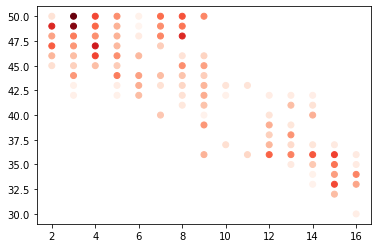

In [15]:
import matplotlib.pyplot as plt
import numpy as np

mask=np.argsort(c_list)[::-1][:100]
plt.scatter(np.array(l_list)[mask],np.array(p_list)[mask],c=np.array(c_list)[mask],cmap='Reds')